In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.auto import tqdm, trange


from pandas_profiling import ProfileReport

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

In [2]:
raw_data1 = pd.read_csv("data/train01.csv", sep=";")
raw_data2 = pd.read_csv("data/train02.csv", sep=";")
test = pd.read_csv("data/test.csv", sep=";")

In [3]:
raw_data = pd.concat([raw_data1, raw_data2])

In [4]:
raw_data.loc[~raw_data["x2"].isnull(), "x2"] = raw_data.loc[~raw_data["x2"].isnull(), "x2"].apply(lambda x: datetime.strptime(x, "%d.%m.%Y").date())
test.loc[~test["x2"].isnull(), "x2"] = test.loc[~test["x2"].isnull(), "x2"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

In [5]:
def str2list(s, sep=None):
    return list(map(float, s[1:-1].split(sep)))


raw_data.drop(["x8", "x9"], axis=1, inplace=True)
test.drop(["x8", "x9"], axis=1, inplace=True)

# train.x8 = train.x8.apply(str2list)
# train.x9 = train.x9.apply(str2list)

for idx in trange(10, 43):
    raw_data[f"x{idx}"] = raw_data[f"x{idx}"].apply(lambda x: str2list(x, sep=", "))
    test[f"x{idx}"] = test[f"x{idx}"].apply(lambda x: str2list(x, sep=", "))

  0%|          | 0/33 [00:00<?, ?it/s]

<BarContainer object of 41 artists>

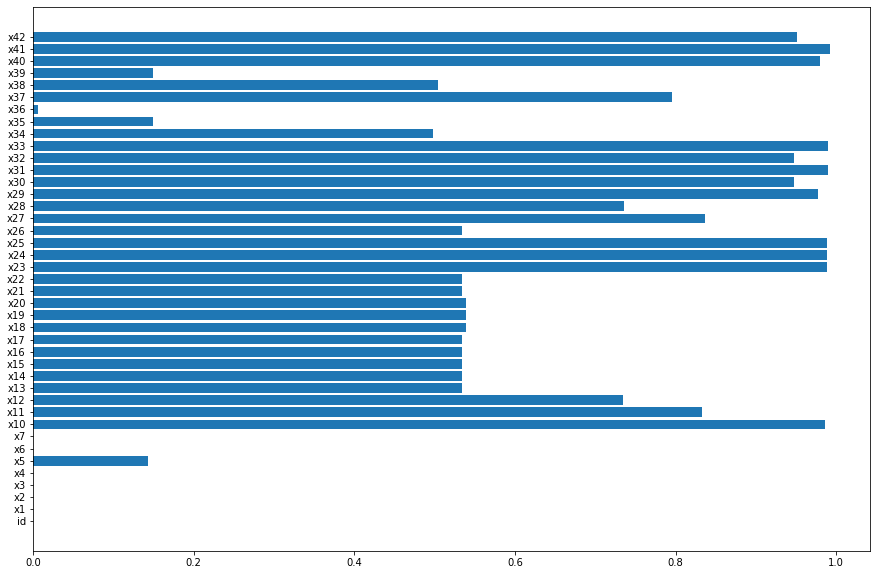

In [6]:
fig = plt.figure(figsize=(15, 10))

nans = {}
for col in raw_data.columns:
    if col == "y":
        continue
    nans[col] = raw_data[col].explode().isnull().mean()

plt.barh(list(nans.keys()), list(nans.values()))

In [7]:
for key, value in nans.items():
    if value >= 0.6:
        raw_data.drop(key, axis=1, inplace=True)
        test.drop(key, axis=1, inplace=True)

In [8]:
raw_data

,id,y,x1,x2,x3,x4,x5,x6,x7,x13,...,x19,x20,x21,x22,x26,x34,x35,x36,x38,x39
0,-9196902500682081904,0,-2201458060675810556,2008-09-01,6312572492787112517,182,-6.347413e+18,2066976859146697559,0,"[nan, 1.0, nan, nan, 1.0, 1.0]",...,"[nan, 0.02, nan, nan, 47.67, 70.6]","[nan, 0.28, nan, nan, 0.0, 9969.07]","[nan, 0.0, nan, nan, 0.0, 0.0]","[nan, 0.0, nan, nan, 0.0, 0.0]","[nan, 0.0, nan, nan, 0.0, 0.0]","[3.0, 2.0, 1.0, nan, nan, 1.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[224.79, 224.79, 224.79, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
1,-9196902500682081900,0,-2201458060675810556,2013-02-05,4293238556669161936,182,-8.465179e+18,-8648529837587014226,0,"[nan, nan, 0.0, 0.0, nan, 0.0]",...,"[nan, nan, 0.0, 0.13, nan, 0.0]","[nan, nan, 0.02, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[nan, nan, 0.0, 0.0, nan, 0.0]","[4.0, nan, nan, 2.0, 3.0, 7.0]","[90.27, 90.27, 90.27, 90.27, 90.27, 90.27]","[249.94, 249.94, 249.94, 249.94, 155.64, 155.64]","[nan, nan, nan, nan, nan, nan]","[103.09, 103.09, 103.09, 103.09, 103.09, 103.09]"
2,-9196902500682081899,0,-2201458060675810556,2008-09-01,6312572492787112517,175,5.417474e+18,-5480331477604673780,1,"[nan, 0.0, nan, nan, nan, nan]",...,"[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[nan, 0.0, nan, nan, nan, nan]","[1.0, nan, nan, nan, nan, 2.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[196.61, 224.79, 197.55, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
3,-9196902500682081897,0,-2201458060675810556,2008-09-01,6312572492787112517,182,-6.347413e+18,-3150357754345161454,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[nan, nan, nan, 1.0, 2.0, 1.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[199.65, 199.65, 199.65, 199.65, 199.65, 199.65]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
4,-9196902500681081897,0,-2201458060675810556,2008-09-01,6312572492787112517,179,6.856367e+18,4900304581511328621,2,"[nan, 0.0, nan, 0.0, nan, nan]",...,"[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[nan, 0.0, nan, 0.0, nan, nan]","[3.0, nan, 2.0, nan, 1.0, 5.0]","[67.64, 67.64, 67.64, 67.64, 67.64, 67.64]","[224.79, 224.79, 224.79, 224.79, 224.79, 224.79]","[nan, nan, nan, nan, nan, nan]","[80.46, 80.46, 80.46, 80.46, 80.46, 80.46]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93184,9162040885608725764,0,-4849479253074186081,2011-12-21,6312572492787112517,167,7.599054e+18,2066976859146697559,1,"[0.0, 0.0, 0.0, 0.0, nan, nan]",...,"[0.0, 0.0, 0.0, 0.01, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[0.0, 0.0, 0.0, 0.0, nan, nan]","[3.0, nan, 3.0, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[149.36, 149.36, 149.36, 99.49, 149.36, 149.36]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
93185,9162040885608725769,0,-4849479253074186081,2016-08-25,6312572492787112517,8,7.599054e+18,-2615825110734950454,0,"[nan, nan, nan, nan, nan, 0.0]",...,"[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[nan, nan, nan, nan, nan, 0.0]","[1.0, 1.0, nan, 1.0, 2.0, 2.0]","[nan, nan, nan, nan, nan, 67.64]","[61.35, 61.35, 61.35, 61.35, 61.35, 61.35]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, 80.46]"
93186,9162040885608725770,0,-4849479253074186081,2013-12-02,6312572492787112517,184,7.599054e+18,2066976859146697559,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",...,"[0.41, 0.31, 0.0, 0.0, 0.46

In [9]:
def agregate(df):
    for col in df.loc[:, "x13":].columns:
        x = np.array(df[col].tolist())

        min_ = np.nanmin(x, axis=1, keepdims=True)
        max_ = np.nanmax(x, axis=1, keepdims=True)
        mean = np.nanmean(x, axis=1, keepdims=True)
        std = np.nanstd(x, axis=1, keepdims=True)
        p = np.isnan(x).mean(1, keepdims=True)

        x[np.isnan(x)] = 0

        x = np.hstack([x, min_, max_, mean, std, p])

        names = [f"{col}_{i}" for i in range(1, 7)] + \
                [f"{col}_min", f"{col}_max", f"{col}_mean", f"{col}_std", f"{col}_nans"]

        df[names] = x

        df.drop(col, axis=1, inplace=True)
        
        
def fill_null(df):
    df.loc[df["x2"].isnull(), "x2"] = datetime(1, 1, 1, 0, 0, 0).date()
    df.loc[df["x1"].isnull(), "x1"] = 0
    df.loc[df["x3"].isnull(), "x3"] = 0
    df.loc[df["x5"].isnull(), "x5"] = 0
    df.loc[df["x6"].isnull(), "x6"] = 0
    
    
def convert_str(df):
    df.x1 = df.x1.astype(str)
    df.x3 = df.x3.astype(str)
    df.x5 = df.x5.astype(str)
    df.x6 = df.x6.astype(str)
    

def convert_date(df):
    df['x2_month'] = df['x2'].apply(lambda x: x.month)
    df['x2_day'] = df['x2'].apply(lambda x: x.day)
    df.drop("x2", axis=1, inplace=True)

In [10]:
agregate(raw_data)
agregate(test)

/tmp/ipykernel_24998/3158839329.py:5: RuntimeWarning: All-NaN slice encountered
  min_ = np.nanmin(x, axis=1, keepdims=True)
/tmp/ipykernel_24998/3158839329.py:6: RuntimeWarning: All-NaN slice encountered
  max_ = np.nanmax(x, axis=1, keepdims=True)
/tmp/ipykernel_24998/3158839329.py:7: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(x, axis=1, keepdims=True)
/home/breengles/.pyenv/versions/3.8.11/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [11]:
fill_null(raw_data)
fill_null(test)

convert_str(raw_data)
convert_str(test)

convert_date(raw_data)
convert_date(test)

In [12]:
unique_ids = pd.unique(raw_data.id)

N = unique_ids.shape[0]

print(N)

train_ids = np.random.choice(unique_ids, size=int(0.95 * N), replace=False)

train = raw_data[raw_data.id.isin(train_ids)].drop(["id", "y"], axis=1).copy().values
y_train = raw_data[raw_data.id.isin(train_ids)]["y"].copy().values

val = raw_data[~raw_data.id.isin(train_ids)].drop(["id", "y"], axis=1).copy().values
y_val = raw_data[~raw_data.id.isin(train_ids)]["y"].copy().values

119967


In [13]:
cat = CatBoostClassifier(task_type="GPU")

cat.fit(train, y_train, [0, 1, 2, 4, 5])

Learning rate set to 0.025368
0:	learn: 0.6440570	total: 25.3ms	remaining: 25.2s
1:	learn: 0.5986478	total: 49.8ms	remaining: 24.9s
2:	learn: 0.5581464	total: 72.5ms	remaining: 24.1s
3:	learn: 0.5215711	total: 92.6ms	remaining: 23.1s
4:	learn: 0.4866286	total: 110ms	remaining: 21.9s
5:	learn: 0.4548850	total: 129ms	remaining: 21.4s
6:	learn: 0.4259378	total: 145ms	remaining: 20.6s
7:	learn: 0.3996621	total: 162ms	remaining: 20.1s
8:	learn: 0.3753033	total: 179ms	remaining: 19.7s
9:	learn: 0.3530635	total: 195ms	remaining: 19.3s
10:	learn: 0.3326573	total: 211ms	remaining: 19s
11:	learn: 0.3141653	total: 228ms	remaining: 18.8s
12:	learn: 0.2972153	total: 246ms	remaining: 18.7s
13:	learn: 0.2817513	total: 264ms	remaining: 18.6s
14:	learn: 0.2677791	total: 280ms	remaining: 18.4s
15:	learn: 0.2549749	total: 298ms	remaining: 18.3s
16:	learn: 0.2431725	total: 315ms	remaining: 18.2s
17:	learn: 0.2325289	total: 332ms	remaining: 18.1s
18:	learn: 0.2228202	total: 349ms	remaining: 18s
19:	learn: 

165:	learn: 0.0803882	total: 3.12s	remaining: 15.7s
166:	learn: 0.0802284	total: 3.14s	remaining: 15.6s
167:	learn: 0.0801772	total: 3.16s	remaining: 15.6s
168:	learn: 0.0800211	total: 3.17s	remaining: 15.6s
169:	learn: 0.0799567	total: 3.19s	remaining: 15.6s
170:	learn: 0.0799120	total: 3.21s	remaining: 15.6s
171:	learn: 0.0798624	total: 3.23s	remaining: 15.6s
172:	learn: 0.0797346	total: 3.25s	remaining: 15.5s
173:	learn: 0.0797276	total: 3.27s	remaining: 15.5s
174:	learn: 0.0796714	total: 3.28s	remaining: 15.5s
175:	learn: 0.0796179	total: 3.3s	remaining: 15.5s
176:	learn: 0.0795712	total: 3.32s	remaining: 15.4s
177:	learn: 0.0795288	total: 3.34s	remaining: 15.4s
178:	learn: 0.0793968	total: 3.36s	remaining: 15.4s
179:	learn: 0.0793398	total: 3.37s	remaining: 15.4s
180:	learn: 0.0792087	total: 3.39s	remaining: 15.4s
181:	learn: 0.0791629	total: 3.41s	remaining: 15.3s
182:	learn: 0.0790854	total: 3.43s	remaining: 15.3s
183:	learn: 0.0789671	total: 3.45s	remaining: 15.3s
184:	learn: 0

328:	learn: 0.0739358	total: 6.25s	remaining: 12.7s
329:	learn: 0.0739328	total: 6.27s	remaining: 12.7s
330:	learn: 0.0739296	total: 6.28s	remaining: 12.7s
331:	learn: 0.0739288	total: 6.3s	remaining: 12.7s
332:	learn: 0.0739033	total: 6.32s	remaining: 12.7s
333:	learn: 0.0738883	total: 6.34s	remaining: 12.6s
334:	learn: 0.0738837	total: 6.36s	remaining: 12.6s
335:	learn: 0.0738749	total: 6.37s	remaining: 12.6s
336:	learn: 0.0738709	total: 6.39s	remaining: 12.6s
337:	learn: 0.0738621	total: 6.41s	remaining: 12.5s
338:	learn: 0.0738600	total: 6.42s	remaining: 12.5s
339:	learn: 0.0738480	total: 6.44s	remaining: 12.5s
340:	learn: 0.0738260	total: 6.46s	remaining: 12.5s
341:	learn: 0.0738209	total: 6.48s	remaining: 12.5s
342:	learn: 0.0738139	total: 6.5s	remaining: 12.4s
343:	learn: 0.0737718	total: 6.52s	remaining: 12.4s
344:	learn: 0.0737320	total: 6.54s	remaining: 12.4s
345:	learn: 0.0737249	total: 6.55s	remaining: 12.4s
346:	learn: 0.0737214	total: 6.57s	remaining: 12.4s
347:	learn: 0.

493:	learn: 0.0723988	total: 9.4s	remaining: 9.63s
494:	learn: 0.0723972	total: 9.42s	remaining: 9.62s
495:	learn: 0.0723959	total: 9.44s	remaining: 9.59s
496:	learn: 0.0723947	total: 9.46s	remaining: 9.57s
497:	learn: 0.0723935	total: 9.48s	remaining: 9.55s
498:	learn: 0.0723930	total: 9.49s	remaining: 9.53s
499:	learn: 0.0723899	total: 9.51s	remaining: 9.51s
500:	learn: 0.0723861	total: 9.54s	remaining: 9.5s
501:	learn: 0.0723835	total: 9.56s	remaining: 9.48s
502:	learn: 0.0723703	total: 9.58s	remaining: 9.46s
503:	learn: 0.0723677	total: 9.6s	remaining: 9.45s
504:	learn: 0.0723643	total: 9.62s	remaining: 9.43s
505:	learn: 0.0723603	total: 9.64s	remaining: 9.41s
506:	learn: 0.0723585	total: 9.65s	remaining: 9.39s
507:	learn: 0.0723540	total: 9.67s	remaining: 9.37s
508:	learn: 0.0723324	total: 9.69s	remaining: 9.35s
509:	learn: 0.0723322	total: 9.71s	remaining: 9.33s
510:	learn: 0.0723138	total: 9.73s	remaining: 9.31s
511:	learn: 0.0723134	total: 9.74s	remaining: 9.29s
512:	learn: 0.0

653:	learn: 0.0711911	total: 12.6s	remaining: 6.66s
654:	learn: 0.0711905	total: 12.6s	remaining: 6.64s
655:	learn: 0.0711903	total: 12.6s	remaining: 6.62s
656:	learn: 0.0711871	total: 12.6s	remaining: 6.6s
657:	learn: 0.0711851	total: 12.7s	remaining: 6.58s
658:	learn: 0.0711830	total: 12.7s	remaining: 6.56s
659:	learn: 0.0711449	total: 12.7s	remaining: 6.54s
660:	learn: 0.0711442	total: 12.7s	remaining: 6.52s
661:	learn: 0.0711416	total: 12.7s	remaining: 6.5s
662:	learn: 0.0711413	total: 12.8s	remaining: 6.48s
663:	learn: 0.0711383	total: 12.8s	remaining: 6.46s
664:	learn: 0.0711333	total: 12.8s	remaining: 6.44s
665:	learn: 0.0711297	total: 12.8s	remaining: 6.42s
666:	learn: 0.0711282	total: 12.8s	remaining: 6.4s
667:	learn: 0.0711271	total: 12.8s	remaining: 6.38s
668:	learn: 0.0711255	total: 12.9s	remaining: 6.36s
669:	learn: 0.0711247	total: 12.9s	remaining: 6.34s
670:	learn: 0.0711198	total: 12.9s	remaining: 6.33s
671:	learn: 0.0711138	total: 12.9s	remaining: 6.31s
672:	learn: 0.0

815:	learn: 0.0704176	total: 15.7s	remaining: 3.55s
816:	learn: 0.0704148	total: 15.8s	remaining: 3.53s
817:	learn: 0.0704114	total: 15.8s	remaining: 3.51s
818:	learn: 0.0704112	total: 15.8s	remaining: 3.49s
819:	learn: 0.0704098	total: 15.8s	remaining: 3.47s
820:	learn: 0.0703933	total: 15.8s	remaining: 3.45s
821:	learn: 0.0703930	total: 15.8s	remaining: 3.43s
822:	learn: 0.0703734	total: 15.9s	remaining: 3.41s
823:	learn: 0.0703657	total: 15.9s	remaining: 3.39s
824:	learn: 0.0703549	total: 15.9s	remaining: 3.37s
825:	learn: 0.0703470	total: 15.9s	remaining: 3.35s
826:	learn: 0.0703400	total: 15.9s	remaining: 3.33s
827:	learn: 0.0703387	total: 16s	remaining: 3.31s
828:	learn: 0.0703384	total: 16s	remaining: 3.29s
829:	learn: 0.0703322	total: 16s	remaining: 3.28s
830:	learn: 0.0702933	total: 16s	remaining: 3.26s
831:	learn: 0.0702907	total: 16s	remaining: 3.24s
832:	learn: 0.0702905	total: 16.1s	remaining: 3.22s
833:	learn: 0.0702875	total: 16.1s	remaining: 3.2s
834:	learn: 0.0702849	t

977:	learn: 0.0697668	total: 18.9s	remaining: 425ms
978:	learn: 0.0697650	total: 18.9s	remaining: 406ms
979:	learn: 0.0697451	total: 18.9s	remaining: 387ms
980:	learn: 0.0697413	total: 19s	remaining: 367ms
981:	learn: 0.0697403	total: 19s	remaining: 348ms
982:	learn: 0.0697386	total: 19s	remaining: 329ms
983:	learn: 0.0697376	total: 19s	remaining: 309ms
984:	learn: 0.0697333	total: 19.1s	remaining: 290ms
985:	learn: 0.0697308	total: 19.1s	remaining: 271ms
986:	learn: 0.0697296	total: 19.1s	remaining: 251ms
987:	learn: 0.0697284	total: 19.1s	remaining: 232ms
988:	learn: 0.0697146	total: 19.1s	remaining: 213ms
989:	learn: 0.0697114	total: 19.2s	remaining: 194ms
990:	learn: 0.0697101	total: 19.2s	remaining: 174ms
991:	learn: 0.0697074	total: 19.2s	remaining: 155ms
992:	learn: 0.0697025	total: 19.2s	remaining: 135ms
993:	learn: 0.0697006	total: 19.2s	remaining: 116ms
994:	learn: 0.0696990	total: 19.3s	remaining: 96.8ms
995:	learn: 0.0696935	total: 19.3s	remaining: 77.4ms
996:	learn: 0.0696

In [14]:
y_pred_proba = cat.predict_proba(val)
y_pred = cat.predict(val)
roc_auc_score(y_val, y_pred_proba[:, 1])

0.894155387915095

In [15]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9014
           1       0.92      0.22      0.36       216

    accuracy                           0.98      9230
   macro avg       0.95      0.61      0.67      9230
weighted avg       0.98      0.98      0.98      9230



CROSS-VAL

In [17]:
cat = CatBoostClassifier(task_type="GPU", cat_features=[0, 1, 2, 4, 5])
scores = cross_val_score(cat, train, y_train, scoring="roc_auc")

Learning rate set to 0.025681
0:	learn: 0.6433856	total: 18.2ms	remaining: 18.1s
1:	learn: 0.5979309	total: 37.7ms	remaining: 18.8s
2:	learn: 0.5564484	total: 54.8ms	remaining: 18.2s
3:	learn: 0.5195211	total: 72ms	remaining: 17.9s
4:	learn: 0.4858404	total: 88.5ms	remaining: 17.6s
5:	learn: 0.4538287	total: 105ms	remaining: 17.5s
6:	learn: 0.4246319	total: 121ms	remaining: 17.2s
7:	learn: 0.3980120	total: 137ms	remaining: 17s
8:	learn: 0.3733894	total: 154ms	remaining: 17s
9:	learn: 0.3514567	total: 170ms	remaining: 16.8s
10:	learn: 0.3313131	total: 185ms	remaining: 16.7s
11:	learn: 0.3128238	total: 202ms	remaining: 16.6s
12:	learn: 0.2960155	total: 217ms	remaining: 16.5s
13:	learn: 0.2806327	total: 235ms	remaining: 16.6s
14:	learn: 0.2667540	total: 252ms	remaining: 16.6s
15:	learn: 0.2540304	total: 268ms	remaining: 16.5s
16:	learn: 0.2423299	total: 285ms	remaining: 16.5s
17:	learn: 0.2317582	total: 302ms	remaining: 16.5s
18:	learn: 0.2221265	total: 317ms	remaining: 16.3s
19:	learn: 0

171:	learn: 0.0813909	total: 2.91s	remaining: 14s
172:	learn: 0.0813568	total: 2.92s	remaining: 14s
173:	learn: 0.0813090	total: 2.94s	remaining: 14s
174:	learn: 0.0812491	total: 2.96s	remaining: 13.9s
175:	learn: 0.0811083	total: 2.98s	remaining: 13.9s
176:	learn: 0.0810882	total: 2.99s	remaining: 13.9s
177:	learn: 0.0810478	total: 3.01s	remaining: 13.9s
178:	learn: 0.0809946	total: 3.02s	remaining: 13.9s
179:	learn: 0.0809321	total: 3.04s	remaining: 13.8s
180:	learn: 0.0807805	total: 3.06s	remaining: 13.8s
181:	learn: 0.0807300	total: 3.07s	remaining: 13.8s
182:	learn: 0.0805883	total: 3.09s	remaining: 13.8s
183:	learn: 0.0804791	total: 3.11s	remaining: 13.8s
184:	learn: 0.0803451	total: 3.12s	remaining: 13.8s
185:	learn: 0.0803194	total: 3.14s	remaining: 13.7s
186:	learn: 0.0802702	total: 3.16s	remaining: 13.7s
187:	learn: 0.0802499	total: 3.17s	remaining: 13.7s
188:	learn: 0.0802451	total: 3.19s	remaining: 13.7s
189:	learn: 0.0801893	total: 3.2s	remaining: 13.7s
190:	learn: 0.08014

339:	learn: 0.0755060	total: 5.83s	remaining: 11.3s
340:	learn: 0.0754587	total: 5.84s	remaining: 11.3s
341:	learn: 0.0754561	total: 5.86s	remaining: 11.3s
342:	learn: 0.0754525	total: 5.88s	remaining: 11.3s
343:	learn: 0.0754303	total: 5.89s	remaining: 11.2s
344:	learn: 0.0754071	total: 5.91s	remaining: 11.2s
345:	learn: 0.0754009	total: 5.92s	remaining: 11.2s
346:	learn: 0.0753954	total: 5.94s	remaining: 11.2s
347:	learn: 0.0753423	total: 5.96s	remaining: 11.2s
348:	learn: 0.0753374	total: 5.97s	remaining: 11.1s
349:	learn: 0.0753151	total: 5.99s	remaining: 11.1s
350:	learn: 0.0752552	total: 6.01s	remaining: 11.1s
351:	learn: 0.0752282	total: 6.02s	remaining: 11.1s
352:	learn: 0.0752251	total: 6.04s	remaining: 11.1s
353:	learn: 0.0751863	total: 6.06s	remaining: 11.1s
354:	learn: 0.0751405	total: 6.07s	remaining: 11s
355:	learn: 0.0751364	total: 6.09s	remaining: 11s
356:	learn: 0.0751170	total: 6.11s	remaining: 11s
357:	learn: 0.0751104	total: 6.12s	remaining: 11s
358:	learn: 0.075099

509:	learn: 0.0738473	total: 8.71s	remaining: 8.37s
510:	learn: 0.0738467	total: 8.73s	remaining: 8.35s
511:	learn: 0.0738462	total: 8.75s	remaining: 8.34s
512:	learn: 0.0738438	total: 8.76s	remaining: 8.32s
513:	learn: 0.0738134	total: 8.78s	remaining: 8.3s
514:	learn: 0.0737312	total: 8.8s	remaining: 8.29s
515:	learn: 0.0737262	total: 8.81s	remaining: 8.27s
516:	learn: 0.0737243	total: 8.83s	remaining: 8.25s
517:	learn: 0.0736935	total: 8.84s	remaining: 8.23s
518:	learn: 0.0736901	total: 8.86s	remaining: 8.21s
519:	learn: 0.0736885	total: 8.88s	remaining: 8.19s
520:	learn: 0.0736849	total: 8.89s	remaining: 8.17s
521:	learn: 0.0736828	total: 8.9s	remaining: 8.15s
522:	learn: 0.0736765	total: 8.92s	remaining: 8.13s
523:	learn: 0.0736748	total: 8.94s	remaining: 8.12s
524:	learn: 0.0736634	total: 8.95s	remaining: 8.1s
525:	learn: 0.0736621	total: 8.97s	remaining: 8.08s
526:	learn: 0.0736611	total: 8.98s	remaining: 8.06s
527:	learn: 0.0736605	total: 9s	remaining: 8.04s
528:	learn: 0.07364

675:	learn: 0.0725752	total: 11.6s	remaining: 5.57s
676:	learn: 0.0725712	total: 11.6s	remaining: 5.55s
677:	learn: 0.0725686	total: 11.7s	remaining: 5.53s
678:	learn: 0.0725659	total: 11.7s	remaining: 5.52s
679:	learn: 0.0725631	total: 11.7s	remaining: 5.5s
680:	learn: 0.0725396	total: 11.7s	remaining: 5.48s
681:	learn: 0.0725373	total: 11.7s	remaining: 5.46s
682:	learn: 0.0725359	total: 11.7s	remaining: 5.45s
683:	learn: 0.0725266	total: 11.8s	remaining: 5.43s
684:	learn: 0.0725254	total: 11.8s	remaining: 5.41s
685:	learn: 0.0725239	total: 11.8s	remaining: 5.39s
686:	learn: 0.0725203	total: 11.8s	remaining: 5.37s
687:	learn: 0.0725160	total: 11.8s	remaining: 5.36s
688:	learn: 0.0724930	total: 11.8s	remaining: 5.34s
689:	learn: 0.0724806	total: 11.8s	remaining: 5.32s
690:	learn: 0.0724741	total: 11.9s	remaining: 5.3s
691:	learn: 0.0724736	total: 11.9s	remaining: 5.29s
692:	learn: 0.0724726	total: 11.9s	remaining: 5.27s
693:	learn: 0.0724688	total: 11.9s	remaining: 5.25s
694:	learn: 0.

842:	learn: 0.0716220	total: 14.5s	remaining: 2.71s
843:	learn: 0.0715956	total: 14.6s	remaining: 2.69s
844:	learn: 0.0715684	total: 14.6s	remaining: 2.67s
845:	learn: 0.0715614	total: 14.6s	remaining: 2.65s
846:	learn: 0.0715600	total: 14.6s	remaining: 2.64s
847:	learn: 0.0715406	total: 14.6s	remaining: 2.62s
848:	learn: 0.0715375	total: 14.6s	remaining: 2.6s
849:	learn: 0.0715371	total: 14.7s	remaining: 2.58s
850:	learn: 0.0715336	total: 14.7s	remaining: 2.57s
851:	learn: 0.0715306	total: 14.7s	remaining: 2.55s
852:	learn: 0.0715273	total: 14.7s	remaining: 2.53s
853:	learn: 0.0715180	total: 14.7s	remaining: 2.52s
854:	learn: 0.0714966	total: 14.7s	remaining: 2.5s
855:	learn: 0.0714887	total: 14.8s	remaining: 2.48s
856:	learn: 0.0714881	total: 14.8s	remaining: 2.46s
857:	learn: 0.0714798	total: 14.8s	remaining: 2.45s
858:	learn: 0.0714775	total: 14.8s	remaining: 2.43s
859:	learn: 0.0714662	total: 14.8s	remaining: 2.41s
860:	learn: 0.0714639	total: 14.8s	remaining: 2.4s
861:	learn: 0.0

1:	learn: 0.5974607	total: 35.7ms	remaining: 17.8s
2:	learn: 0.5554035	total: 54ms	remaining: 18s
3:	learn: 0.5187369	total: 69.9ms	remaining: 17.4s
4:	learn: 0.4855769	total: 86ms	remaining: 17.1s
5:	learn: 0.4537320	total: 103ms	remaining: 17s
6:	learn: 0.4246739	total: 119ms	remaining: 16.8s
7:	learn: 0.3981673	total: 135ms	remaining: 16.7s
8:	learn: 0.3737658	total: 151ms	remaining: 16.7s
9:	learn: 0.3516194	total: 168ms	remaining: 16.6s
10:	learn: 0.3311978	total: 185ms	remaining: 16.6s
11:	learn: 0.3127777	total: 200ms	remaining: 16.5s
12:	learn: 0.2959198	total: 217ms	remaining: 16.5s
13:	learn: 0.2805543	total: 236ms	remaining: 16.6s
14:	learn: 0.2664702	total: 254ms	remaining: 16.7s
15:	learn: 0.2537847	total: 271ms	remaining: 16.7s
16:	learn: 0.2420834	total: 287ms	remaining: 16.6s
17:	learn: 0.2314618	total: 304ms	remaining: 16.6s
18:	learn: 0.2218507	total: 323ms	remaining: 16.7s
19:	learn: 0.2129752	total: 340ms	remaining: 16.6s
20:	learn: 0.2048885	total: 359ms	remaining:

173:	learn: 0.0793668	total: 2.95s	remaining: 14s
174:	learn: 0.0793019	total: 2.97s	remaining: 14s
175:	learn: 0.0791639	total: 2.98s	remaining: 14s
176:	learn: 0.0791271	total: 3s	remaining: 14s
177:	learn: 0.0790843	total: 3.02s	remaining: 13.9s
178:	learn: 0.0789555	total: 3.03s	remaining: 13.9s
179:	learn: 0.0788963	total: 3.05s	remaining: 13.9s
180:	learn: 0.0788448	total: 3.07s	remaining: 13.9s
181:	learn: 0.0787713	total: 3.08s	remaining: 13.9s
182:	learn: 0.0787332	total: 3.1s	remaining: 13.8s
183:	learn: 0.0786633	total: 3.12s	remaining: 13.8s
184:	learn: 0.0786574	total: 3.13s	remaining: 13.8s
185:	learn: 0.0786094	total: 3.15s	remaining: 13.8s
186:	learn: 0.0784821	total: 3.17s	remaining: 13.8s
187:	learn: 0.0784629	total: 3.18s	remaining: 13.7s
188:	learn: 0.0784169	total: 3.19s	remaining: 13.7s
189:	learn: 0.0783728	total: 3.21s	remaining: 13.7s
190:	learn: 0.0782694	total: 3.23s	remaining: 13.7s
191:	learn: 0.0782278	total: 3.24s	remaining: 13.6s
192:	learn: 0.0781834	to

340:	learn: 0.0735211	total: 5.87s	remaining: 11.3s
341:	learn: 0.0735195	total: 5.88s	remaining: 11.3s
342:	learn: 0.0735112	total: 5.9s	remaining: 11.3s
343:	learn: 0.0734832	total: 5.92s	remaining: 11.3s
344:	learn: 0.0734827	total: 5.93s	remaining: 11.3s
345:	learn: 0.0734788	total: 5.95s	remaining: 11.2s
346:	learn: 0.0734729	total: 5.97s	remaining: 11.2s
347:	learn: 0.0734707	total: 5.99s	remaining: 11.2s
348:	learn: 0.0734697	total: 6s	remaining: 11.2s
349:	learn: 0.0734562	total: 6.01s	remaining: 11.2s
350:	learn: 0.0734413	total: 6.03s	remaining: 11.2s
351:	learn: 0.0734122	total: 6.05s	remaining: 11.1s
352:	learn: 0.0733983	total: 6.08s	remaining: 11.1s
353:	learn: 0.0733786	total: 6.09s	remaining: 11.1s
354:	learn: 0.0733770	total: 6.11s	remaining: 11.1s
355:	learn: 0.0733741	total: 6.13s	remaining: 11.1s
356:	learn: 0.0733733	total: 6.15s	remaining: 11.1s
357:	learn: 0.0733692	total: 6.17s	remaining: 11.1s
358:	learn: 0.0733683	total: 6.18s	remaining: 11s
359:	learn: 0.0733

507:	learn: 0.0722496	total: 8.75s	remaining: 8.47s
508:	learn: 0.0722452	total: 8.77s	remaining: 8.46s
509:	learn: 0.0722419	total: 8.78s	remaining: 8.44s
510:	learn: 0.0722379	total: 8.8s	remaining: 8.42s
511:	learn: 0.0722220	total: 8.81s	remaining: 8.4s
512:	learn: 0.0722213	total: 8.83s	remaining: 8.38s
513:	learn: 0.0722165	total: 8.85s	remaining: 8.36s
514:	learn: 0.0722124	total: 8.86s	remaining: 8.35s
515:	learn: 0.0721860	total: 8.88s	remaining: 8.33s
516:	learn: 0.0721840	total: 8.89s	remaining: 8.31s
517:	learn: 0.0721420	total: 8.91s	remaining: 8.29s
518:	learn: 0.0721152	total: 8.93s	remaining: 8.27s
519:	learn: 0.0721135	total: 8.94s	remaining: 8.25s
520:	learn: 0.0721052	total: 8.96s	remaining: 8.23s
521:	learn: 0.0721017	total: 8.97s	remaining: 8.21s
522:	learn: 0.0720977	total: 8.99s	remaining: 8.2s
523:	learn: 0.0720971	total: 9s	remaining: 8.18s
524:	learn: 0.0720909	total: 9.02s	remaining: 8.16s
525:	learn: 0.0720901	total: 9.03s	remaining: 8.14s
526:	learn: 0.0720

670:	learn: 0.0710589	total: 11.7s	remaining: 5.71s
671:	learn: 0.0710496	total: 11.7s	remaining: 5.7s
672:	learn: 0.0710297	total: 11.7s	remaining: 5.68s
673:	learn: 0.0710293	total: 11.7s	remaining: 5.66s
674:	learn: 0.0710105	total: 11.7s	remaining: 5.64s
675:	learn: 0.0709940	total: 11.7s	remaining: 5.63s
676:	learn: 0.0709883	total: 11.8s	remaining: 5.61s
677:	learn: 0.0709854	total: 11.8s	remaining: 5.59s
678:	learn: 0.0709812	total: 11.8s	remaining: 5.57s
679:	learn: 0.0709795	total: 11.8s	remaining: 5.55s
680:	learn: 0.0709779	total: 11.8s	remaining: 5.53s
681:	learn: 0.0709738	total: 11.8s	remaining: 5.52s
682:	learn: 0.0709731	total: 11.8s	remaining: 5.5s
683:	learn: 0.0709670	total: 11.9s	remaining: 5.48s
684:	learn: 0.0709644	total: 11.9s	remaining: 5.46s
685:	learn: 0.0709579	total: 11.9s	remaining: 5.44s
686:	learn: 0.0709437	total: 11.9s	remaining: 5.43s
687:	learn: 0.0709420	total: 11.9s	remaining: 5.41s
688:	learn: 0.0709382	total: 11.9s	remaining: 5.39s
689:	learn: 0.

835:	learn: 0.0701749	total: 14.5s	remaining: 2.85s
836:	learn: 0.0701731	total: 14.6s	remaining: 2.84s
837:	learn: 0.0701715	total: 14.6s	remaining: 2.82s
838:	learn: 0.0701670	total: 14.6s	remaining: 2.8s
839:	learn: 0.0701622	total: 14.6s	remaining: 2.79s
840:	learn: 0.0701607	total: 14.6s	remaining: 2.77s
841:	learn: 0.0701602	total: 14.7s	remaining: 2.75s
842:	learn: 0.0701598	total: 14.7s	remaining: 2.73s
843:	learn: 0.0701339	total: 14.7s	remaining: 2.71s
844:	learn: 0.0701306	total: 14.7s	remaining: 2.7s
845:	learn: 0.0701285	total: 14.7s	remaining: 2.68s
846:	learn: 0.0701275	total: 14.7s	remaining: 2.66s
847:	learn: 0.0701267	total: 14.8s	remaining: 2.64s
848:	learn: 0.0701124	total: 14.8s	remaining: 2.63s
849:	learn: 0.0701068	total: 14.8s	remaining: 2.61s
850:	learn: 0.0701044	total: 14.8s	remaining: 2.59s
851:	learn: 0.0701012	total: 14.8s	remaining: 2.57s
852:	learn: 0.0700986	total: 14.8s	remaining: 2.56s
853:	learn: 0.0700853	total: 14.9s	remaining: 2.54s
854:	learn: 0.

999:	learn: 0.0692742	total: 17.5s	remaining: 0us
Learning rate set to 0.025681
0:	learn: 0.6435472	total: 23.9ms	remaining: 23.9s
1:	learn: 0.5977025	total: 45.4ms	remaining: 22.7s
2:	learn: 0.5559687	total: 68.4ms	remaining: 22.7s
3:	learn: 0.5191604	total: 89.5ms	remaining: 22.3s
4:	learn: 0.4860251	total: 109ms	remaining: 21.8s
5:	learn: 0.4537481	total: 131ms	remaining: 21.7s
6:	learn: 0.4245028	total: 153ms	remaining: 21.7s
7:	learn: 0.3979798	total: 175ms	remaining: 21.8s
8:	learn: 0.3734057	total: 196ms	remaining: 21.6s
9:	learn: 0.3512868	total: 214ms	remaining: 21.2s
10:	learn: 0.3310641	total: 233ms	remaining: 20.9s
11:	learn: 0.3124309	total: 251ms	remaining: 20.7s
12:	learn: 0.2956278	total: 268ms	remaining: 20.4s
13:	learn: 0.2802591	total: 286ms	remaining: 20.2s
14:	learn: 0.2662914	total: 304ms	remaining: 19.9s
15:	learn: 0.2535858	total: 322ms	remaining: 19.8s
16:	learn: 0.2419251	total: 340ms	remaining: 19.6s
17:	learn: 0.2313450	total: 360ms	remaining: 19.6s
18:	lear

160:	learn: 0.0805794	total: 2.74s	remaining: 14.3s
161:	learn: 0.0805304	total: 2.76s	remaining: 14.3s
162:	learn: 0.0803576	total: 2.78s	remaining: 14.3s
163:	learn: 0.0802017	total: 2.79s	remaining: 14.2s
164:	learn: 0.0801370	total: 2.81s	remaining: 14.2s
165:	learn: 0.0800391	total: 2.83s	remaining: 14.2s
166:	learn: 0.0799799	total: 2.84s	remaining: 14.2s
167:	learn: 0.0799303	total: 2.86s	remaining: 14.2s
168:	learn: 0.0797838	total: 2.88s	remaining: 14.1s
169:	learn: 0.0797251	total: 2.89s	remaining: 14.1s
170:	learn: 0.0795649	total: 2.91s	remaining: 14.1s
171:	learn: 0.0794247	total: 2.93s	remaining: 14.1s
172:	learn: 0.0793938	total: 2.95s	remaining: 14.1s
173:	learn: 0.0793516	total: 2.98s	remaining: 14.1s
174:	learn: 0.0792918	total: 3s	remaining: 14.1s
175:	learn: 0.0792265	total: 3.02s	remaining: 14.1s
176:	learn: 0.0791843	total: 3.04s	remaining: 14.1s
177:	learn: 0.0791430	total: 3.05s	remaining: 14.1s
178:	learn: 0.0790128	total: 3.08s	remaining: 14.1s
179:	learn: 0.0

321:	learn: 0.0736523	total: 5.62s	remaining: 11.8s
322:	learn: 0.0736482	total: 5.64s	remaining: 11.8s
323:	learn: 0.0736469	total: 5.66s	remaining: 11.8s
324:	learn: 0.0736360	total: 5.68s	remaining: 11.8s
325:	learn: 0.0736325	total: 5.69s	remaining: 11.8s
326:	learn: 0.0736202	total: 5.71s	remaining: 11.8s
327:	learn: 0.0736000	total: 5.73s	remaining: 11.7s
328:	learn: 0.0735967	total: 5.74s	remaining: 11.7s
329:	learn: 0.0735373	total: 5.76s	remaining: 11.7s
330:	learn: 0.0735203	total: 5.78s	remaining: 11.7s
331:	learn: 0.0735192	total: 5.79s	remaining: 11.7s
332:	learn: 0.0734989	total: 5.81s	remaining: 11.6s
333:	learn: 0.0734967	total: 5.83s	remaining: 11.6s
334:	learn: 0.0734956	total: 5.84s	remaining: 11.6s
335:	learn: 0.0734771	total: 5.86s	remaining: 11.6s
336:	learn: 0.0734746	total: 5.88s	remaining: 11.6s
337:	learn: 0.0734729	total: 5.89s	remaining: 11.5s
338:	learn: 0.0734675	total: 5.92s	remaining: 11.5s
339:	learn: 0.0734579	total: 5.94s	remaining: 11.5s
340:	learn: 

490:	learn: 0.0722599	total: 8.57s	remaining: 8.88s
491:	learn: 0.0722584	total: 8.59s	remaining: 8.86s
492:	learn: 0.0722515	total: 8.6s	remaining: 8.85s
493:	learn: 0.0722509	total: 8.62s	remaining: 8.82s
494:	learn: 0.0722504	total: 8.63s	remaining: 8.8s
495:	learn: 0.0722473	total: 8.64s	remaining: 8.79s
496:	learn: 0.0722281	total: 8.66s	remaining: 8.77s
497:	learn: 0.0722270	total: 8.68s	remaining: 8.75s
498:	learn: 0.0722252	total: 8.69s	remaining: 8.73s
499:	learn: 0.0722248	total: 8.71s	remaining: 8.71s
500:	learn: 0.0722241	total: 8.72s	remaining: 8.69s
501:	learn: 0.0722112	total: 8.74s	remaining: 8.67s
502:	learn: 0.0722101	total: 8.76s	remaining: 8.65s
503:	learn: 0.0722091	total: 8.77s	remaining: 8.63s
504:	learn: 0.0722064	total: 8.79s	remaining: 8.62s
505:	learn: 0.0722044	total: 8.8s	remaining: 8.6s
506:	learn: 0.0722005	total: 8.82s	remaining: 8.58s
507:	learn: 0.0721968	total: 8.84s	remaining: 8.56s
508:	learn: 0.0721881	total: 8.85s	remaining: 8.54s
509:	learn: 0.07

657:	learn: 0.0713489	total: 11.5s	remaining: 5.96s
658:	learn: 0.0713469	total: 11.5s	remaining: 5.94s
659:	learn: 0.0713463	total: 11.5s	remaining: 5.92s
660:	learn: 0.0713440	total: 11.5s	remaining: 5.9s
661:	learn: 0.0713433	total: 11.5s	remaining: 5.88s
662:	learn: 0.0713417	total: 11.5s	remaining: 5.87s
663:	learn: 0.0713344	total: 11.6s	remaining: 5.85s
664:	learn: 0.0713290	total: 11.6s	remaining: 5.83s
665:	learn: 0.0713264	total: 11.6s	remaining: 5.81s
666:	learn: 0.0713256	total: 11.6s	remaining: 5.79s
667:	learn: 0.0713231	total: 11.6s	remaining: 5.78s
668:	learn: 0.0713085	total: 11.6s	remaining: 5.76s
669:	learn: 0.0713053	total: 11.7s	remaining: 5.74s
670:	learn: 0.0713046	total: 11.7s	remaining: 5.72s
671:	learn: 0.0712967	total: 11.7s	remaining: 5.7s
672:	learn: 0.0712935	total: 11.7s	remaining: 5.69s
673:	learn: 0.0712903	total: 11.7s	remaining: 5.67s
674:	learn: 0.0712901	total: 11.7s	remaining: 5.65s
675:	learn: 0.0712611	total: 11.8s	remaining: 5.63s
676:	learn: 0.

817:	learn: 0.0705651	total: 14.2s	remaining: 3.16s
818:	learn: 0.0705606	total: 14.2s	remaining: 3.14s
819:	learn: 0.0705590	total: 14.2s	remaining: 3.13s
820:	learn: 0.0705257	total: 14.3s	remaining: 3.11s
821:	learn: 0.0705089	total: 14.3s	remaining: 3.09s
822:	learn: 0.0705051	total: 14.3s	remaining: 3.07s
823:	learn: 0.0705020	total: 14.3s	remaining: 3.06s
824:	learn: 0.0704997	total: 14.3s	remaining: 3.04s
825:	learn: 0.0704965	total: 14.3s	remaining: 3.02s
826:	learn: 0.0704960	total: 14.4s	remaining: 3s
827:	learn: 0.0704916	total: 14.4s	remaining: 2.98s
828:	learn: 0.0704907	total: 14.4s	remaining: 2.97s
829:	learn: 0.0704864	total: 14.4s	remaining: 2.95s
830:	learn: 0.0704850	total: 14.4s	remaining: 2.93s
831:	learn: 0.0704838	total: 14.4s	remaining: 2.91s
832:	learn: 0.0704789	total: 14.5s	remaining: 2.9s
833:	learn: 0.0704771	total: 14.5s	remaining: 2.88s
834:	learn: 0.0704762	total: 14.5s	remaining: 2.86s
835:	learn: 0.0704748	total: 14.5s	remaining: 2.84s
836:	learn: 0.07

987:	learn: 0.0697218	total: 17.1s	remaining: 208ms
988:	learn: 0.0697208	total: 17.2s	remaining: 191ms
989:	learn: 0.0697062	total: 17.2s	remaining: 173ms
990:	learn: 0.0697047	total: 17.2s	remaining: 156ms
991:	learn: 0.0697044	total: 17.2s	remaining: 139ms
992:	learn: 0.0697029	total: 17.2s	remaining: 121ms
993:	learn: 0.0696908	total: 17.2s	remaining: 104ms
994:	learn: 0.0696893	total: 17.3s	remaining: 86.7ms
995:	learn: 0.0696884	total: 17.3s	remaining: 69.4ms
996:	learn: 0.0696870	total: 17.3s	remaining: 52ms
997:	learn: 0.0696825	total: 17.3s	remaining: 34.7ms
998:	learn: 0.0696817	total: 17.3s	remaining: 17.3ms
999:	learn: 0.0696802	total: 17.3s	remaining: 0us
Learning rate set to 0.025681
0:	learn: 0.6440272	total: 22.9ms	remaining: 22.9s
1:	learn: 0.5978091	total: 43.8ms	remaining: 21.9s
2:	learn: 0.5555699	total: 67.2ms	remaining: 22.3s
3:	learn: 0.5187756	total: 88.3ms	remaining: 22s
4:	learn: 0.4838968	total: 109ms	remaining: 21.6s
5:	learn: 0.4518040	total: 131ms	remainin

153:	learn: 0.0814760	total: 2.76s	remaining: 15.2s
154:	learn: 0.0812791	total: 2.78s	remaining: 15.2s
155:	learn: 0.0812423	total: 2.8s	remaining: 15.2s
156:	learn: 0.0811921	total: 2.82s	remaining: 15.2s
157:	learn: 0.0811474	total: 2.84s	remaining: 15.2s
158:	learn: 0.0810845	total: 2.86s	remaining: 15.1s
159:	learn: 0.0810476	total: 2.89s	remaining: 15.2s
160:	learn: 0.0810148	total: 2.91s	remaining: 15.1s
161:	learn: 0.0809655	total: 2.93s	remaining: 15.1s
162:	learn: 0.0807831	total: 2.95s	remaining: 15.1s
163:	learn: 0.0807337	total: 2.97s	remaining: 15.1s
164:	learn: 0.0806667	total: 2.99s	remaining: 15.2s
165:	learn: 0.0805667	total: 3.01s	remaining: 15.1s
166:	learn: 0.0805014	total: 3.04s	remaining: 15.1s
167:	learn: 0.0804593	total: 3.06s	remaining: 15.1s
168:	learn: 0.0804190	total: 3.08s	remaining: 15.1s
169:	learn: 0.0803845	total: 3.1s	remaining: 15.1s
170:	learn: 0.0803458	total: 3.11s	remaining: 15.1s
171:	learn: 0.0801817	total: 3.14s	remaining: 15.1s
172:	learn: 0.

315:	learn: 0.0741841	total: 5.67s	remaining: 12.3s
316:	learn: 0.0741265	total: 5.69s	remaining: 12.3s
317:	learn: 0.0741253	total: 5.71s	remaining: 12.2s
318:	learn: 0.0740609	total: 5.73s	remaining: 12.2s
319:	learn: 0.0740184	total: 5.75s	remaining: 12.2s
320:	learn: 0.0740001	total: 5.77s	remaining: 12.2s
321:	learn: 0.0739369	total: 5.79s	remaining: 12.2s
322:	learn: 0.0739359	total: 5.81s	remaining: 12.2s
323:	learn: 0.0739329	total: 5.83s	remaining: 12.2s
324:	learn: 0.0739262	total: 5.84s	remaining: 12.1s
325:	learn: 0.0739209	total: 5.87s	remaining: 12.1s
326:	learn: 0.0739181	total: 5.89s	remaining: 12.1s
327:	learn: 0.0738807	total: 5.91s	remaining: 12.1s
328:	learn: 0.0738789	total: 5.93s	remaining: 12.1s
329:	learn: 0.0738741	total: 5.95s	remaining: 12.1s
330:	learn: 0.0738717	total: 5.97s	remaining: 12.1s
331:	learn: 0.0738674	total: 5.99s	remaining: 12s
332:	learn: 0.0738027	total: 6.01s	remaining: 12s
333:	learn: 0.0737847	total: 6.03s	remaining: 12s
334:	learn: 0.0737

484:	learn: 0.0726012	total: 8.57s	remaining: 9.1s
485:	learn: 0.0725948	total: 8.58s	remaining: 9.08s
486:	learn: 0.0725942	total: 8.6s	remaining: 9.06s
487:	learn: 0.0725938	total: 8.61s	remaining: 9.04s
488:	learn: 0.0725927	total: 8.63s	remaining: 9.02s
489:	learn: 0.0725721	total: 8.65s	remaining: 9.01s
490:	learn: 0.0725717	total: 8.67s	remaining: 8.99s
491:	learn: 0.0725692	total: 8.69s	remaining: 8.97s
492:	learn: 0.0725570	total: 8.71s	remaining: 8.96s
493:	learn: 0.0725179	total: 8.73s	remaining: 8.94s
494:	learn: 0.0725175	total: 8.75s	remaining: 8.93s
495:	learn: 0.0725171	total: 8.77s	remaining: 8.91s
496:	learn: 0.0725122	total: 8.79s	remaining: 8.89s
497:	learn: 0.0725055	total: 8.81s	remaining: 8.88s
498:	learn: 0.0725037	total: 8.83s	remaining: 8.86s
499:	learn: 0.0725016	total: 8.85s	remaining: 8.85s
500:	learn: 0.0725008	total: 8.87s	remaining: 8.84s
501:	learn: 0.0724984	total: 8.89s	remaining: 8.82s
502:	learn: 0.0724969	total: 8.91s	remaining: 8.8s
503:	learn: 0.0

653:	learn: 0.0714880	total: 11.5s	remaining: 6.07s
654:	learn: 0.0714871	total: 11.5s	remaining: 6.05s
655:	learn: 0.0714862	total: 11.5s	remaining: 6.03s
656:	learn: 0.0714859	total: 11.5s	remaining: 6.01s
657:	learn: 0.0714832	total: 11.5s	remaining: 5.99s
658:	learn: 0.0714794	total: 11.5s	remaining: 5.97s
659:	learn: 0.0714787	total: 11.6s	remaining: 5.96s
660:	learn: 0.0714694	total: 11.6s	remaining: 5.94s
661:	learn: 0.0714675	total: 11.6s	remaining: 5.92s
662:	learn: 0.0714629	total: 11.6s	remaining: 5.9s
663:	learn: 0.0714613	total: 11.6s	remaining: 5.88s
664:	learn: 0.0714599	total: 11.7s	remaining: 5.87s
665:	learn: 0.0714569	total: 11.7s	remaining: 5.85s
666:	learn: 0.0714545	total: 11.7s	remaining: 5.83s
667:	learn: 0.0714526	total: 11.7s	remaining: 5.82s
668:	learn: 0.0714504	total: 11.7s	remaining: 5.8s
669:	learn: 0.0714484	total: 11.7s	remaining: 5.79s
670:	learn: 0.0714474	total: 11.8s	remaining: 5.77s
671:	learn: 0.0714373	total: 11.8s	remaining: 5.75s
672:	learn: 0.

822:	learn: 0.0706287	total: 14.8s	remaining: 3.18s
823:	learn: 0.0706273	total: 14.8s	remaining: 3.16s
824:	learn: 0.0706263	total: 14.8s	remaining: 3.15s
825:	learn: 0.0706256	total: 14.8s	remaining: 3.13s
826:	learn: 0.0706239	total: 14.9s	remaining: 3.11s
827:	learn: 0.0705827	total: 14.9s	remaining: 3.09s
828:	learn: 0.0705793	total: 14.9s	remaining: 3.07s
829:	learn: 0.0705565	total: 14.9s	remaining: 3.06s
830:	learn: 0.0705536	total: 14.9s	remaining: 3.04s
831:	learn: 0.0705530	total: 15s	remaining: 3.02s
832:	learn: 0.0705143	total: 15s	remaining: 3s
833:	learn: 0.0705098	total: 15s	remaining: 2.99s
834:	learn: 0.0705093	total: 15s	remaining: 2.97s
835:	learn: 0.0705079	total: 15.1s	remaining: 2.95s
836:	learn: 0.0705076	total: 15.1s	remaining: 2.94s
837:	learn: 0.0704940	total: 15.1s	remaining: 2.92s
838:	learn: 0.0704778	total: 15.1s	remaining: 2.9s
839:	learn: 0.0704429	total: 15.1s	remaining: 2.88s
840:	learn: 0.0704420	total: 15.2s	remaining: 2.87s
841:	learn: 0.0704235	to

988:	learn: 0.0696181	total: 18.1s	remaining: 202ms
989:	learn: 0.0696159	total: 18.2s	remaining: 183ms
990:	learn: 0.0696116	total: 18.2s	remaining: 165ms
991:	learn: 0.0695928	total: 18.2s	remaining: 147ms
992:	learn: 0.0695778	total: 18.2s	remaining: 128ms
993:	learn: 0.0695764	total: 18.2s	remaining: 110ms
994:	learn: 0.0695733	total: 18.2s	remaining: 91.7ms
995:	learn: 0.0695725	total: 18.3s	remaining: 73.3ms
996:	learn: 0.0695701	total: 18.3s	remaining: 55ms
997:	learn: 0.0695690	total: 18.3s	remaining: 36.7ms
998:	learn: 0.0695678	total: 18.3s	remaining: 18.3ms
999:	learn: 0.0695573	total: 18.3s	remaining: 0us
Learning rate set to 0.025681
0:	learn: 0.6433225	total: 23.2ms	remaining: 23.2s
1:	learn: 0.5968248	total: 47.9ms	remaining: 23.9s
2:	learn: 0.5556869	total: 70.3ms	remaining: 23.3s
3:	learn: 0.5185368	total: 92.5ms	remaining: 23s
4:	learn: 0.4845408	total: 116ms	remaining: 23s
5:	learn: 0.4528345	total: 138ms	remaining: 22.9s
6:	learn: 0.4239307	total: 161ms	remaining: 2

149:	learn: 0.0814071	total: 2.98s	remaining: 16.9s
150:	learn: 0.0813258	total: 3s	remaining: 16.9s
151:	learn: 0.0811051	total: 3.02s	remaining: 16.8s
152:	learn: 0.0809480	total: 3.03s	remaining: 16.8s
153:	learn: 0.0808967	total: 3.05s	remaining: 16.8s
154:	learn: 0.0808140	total: 3.07s	remaining: 16.7s
155:	learn: 0.0807428	total: 3.08s	remaining: 16.7s
156:	learn: 0.0805367	total: 3.1s	remaining: 16.7s
157:	learn: 0.0803562	total: 3.12s	remaining: 16.6s
158:	learn: 0.0802806	total: 3.14s	remaining: 16.6s
159:	learn: 0.0802098	total: 3.16s	remaining: 16.6s
160:	learn: 0.0801685	total: 3.18s	remaining: 16.6s
161:	learn: 0.0801077	total: 3.2s	remaining: 16.5s
162:	learn: 0.0799277	total: 3.22s	remaining: 16.5s
163:	learn: 0.0798587	total: 3.24s	remaining: 16.5s
164:	learn: 0.0798191	total: 3.26s	remaining: 16.5s
165:	learn: 0.0797460	total: 3.28s	remaining: 16.5s
166:	learn: 0.0796882	total: 3.3s	remaining: 16.4s
167:	learn: 0.0796368	total: 3.32s	remaining: 16.4s
168:	learn: 0.0795

311:	learn: 0.0734058	total: 5.88s	remaining: 13s
312:	learn: 0.0733841	total: 5.89s	remaining: 12.9s
313:	learn: 0.0733434	total: 5.91s	remaining: 12.9s
314:	learn: 0.0733185	total: 5.93s	remaining: 12.9s
315:	learn: 0.0733126	total: 5.94s	remaining: 12.9s
316:	learn: 0.0732826	total: 5.96s	remaining: 12.8s
317:	learn: 0.0732816	total: 5.97s	remaining: 12.8s
318:	learn: 0.0732731	total: 5.99s	remaining: 12.8s
319:	learn: 0.0732563	total: 6.01s	remaining: 12.8s
320:	learn: 0.0732490	total: 6.03s	remaining: 12.7s
321:	learn: 0.0732473	total: 6.04s	remaining: 12.7s
322:	learn: 0.0732205	total: 6.06s	remaining: 12.7s
323:	learn: 0.0732034	total: 6.08s	remaining: 12.7s
324:	learn: 0.0731969	total: 6.09s	remaining: 12.7s
325:	learn: 0.0731940	total: 6.11s	remaining: 12.6s
326:	learn: 0.0731910	total: 6.12s	remaining: 12.6s
327:	learn: 0.0731644	total: 6.14s	remaining: 12.6s
328:	learn: 0.0730880	total: 6.16s	remaining: 12.6s
329:	learn: 0.0730838	total: 6.17s	remaining: 12.5s
330:	learn: 0.

475:	learn: 0.0716184	total: 8.58s	remaining: 9.45s
476:	learn: 0.0716162	total: 8.6s	remaining: 9.43s
477:	learn: 0.0715630	total: 8.61s	remaining: 9.41s
478:	learn: 0.0715622	total: 8.63s	remaining: 9.39s
479:	learn: 0.0715593	total: 8.65s	remaining: 9.37s
480:	learn: 0.0715571	total: 8.66s	remaining: 9.35s
481:	learn: 0.0715557	total: 8.68s	remaining: 9.33s
482:	learn: 0.0715543	total: 8.7s	remaining: 9.31s
483:	learn: 0.0715423	total: 8.71s	remaining: 9.29s
484:	learn: 0.0715420	total: 8.73s	remaining: 9.27s
485:	learn: 0.0715400	total: 8.74s	remaining: 9.25s
486:	learn: 0.0715358	total: 8.76s	remaining: 9.23s
487:	learn: 0.0715354	total: 8.78s	remaining: 9.21s
488:	learn: 0.0715338	total: 8.79s	remaining: 9.19s
489:	learn: 0.0715276	total: 8.81s	remaining: 9.17s
490:	learn: 0.0715261	total: 8.83s	remaining: 9.15s
491:	learn: 0.0715244	total: 8.84s	remaining: 9.13s
492:	learn: 0.0715204	total: 8.86s	remaining: 9.11s
493:	learn: 0.0715193	total: 8.88s	remaining: 9.09s
494:	learn: 0.

642:	learn: 0.0705757	total: 11.3s	remaining: 6.29s
643:	learn: 0.0705738	total: 11.3s	remaining: 6.27s
644:	learn: 0.0705723	total: 11.4s	remaining: 6.25s
645:	learn: 0.0705702	total: 11.4s	remaining: 6.24s
646:	learn: 0.0705694	total: 11.4s	remaining: 6.22s
647:	learn: 0.0705684	total: 11.4s	remaining: 6.2s
648:	learn: 0.0705655	total: 11.4s	remaining: 6.19s
649:	learn: 0.0705640	total: 11.5s	remaining: 6.17s
650:	learn: 0.0705632	total: 11.5s	remaining: 6.15s
651:	learn: 0.0705603	total: 11.5s	remaining: 6.13s
652:	learn: 0.0705468	total: 11.5s	remaining: 6.12s
653:	learn: 0.0705456	total: 11.5s	remaining: 6.1s
654:	learn: 0.0705450	total: 11.5s	remaining: 6.08s
655:	learn: 0.0705447	total: 11.6s	remaining: 6.06s
656:	learn: 0.0705445	total: 11.6s	remaining: 6.04s
657:	learn: 0.0705414	total: 11.6s	remaining: 6.02s
658:	learn: 0.0705401	total: 11.6s	remaining: 6s
659:	learn: 0.0705291	total: 11.6s	remaining: 5.99s
660:	learn: 0.0705261	total: 11.6s	remaining: 5.97s
661:	learn: 0.070

802:	learn: 0.0697477	total: 14.2s	remaining: 3.49s
803:	learn: 0.0697464	total: 14.3s	remaining: 3.48s
804:	learn: 0.0697429	total: 14.3s	remaining: 3.46s
805:	learn: 0.0697365	total: 14.3s	remaining: 3.44s
806:	learn: 0.0697337	total: 14.3s	remaining: 3.42s
807:	learn: 0.0697305	total: 14.3s	remaining: 3.4s
808:	learn: 0.0697283	total: 14.3s	remaining: 3.39s
809:	learn: 0.0697276	total: 14.4s	remaining: 3.37s
810:	learn: 0.0697240	total: 14.4s	remaining: 3.35s
811:	learn: 0.0697229	total: 14.4s	remaining: 3.33s
812:	learn: 0.0697113	total: 14.4s	remaining: 3.32s
813:	learn: 0.0697093	total: 14.4s	remaining: 3.3s
814:	learn: 0.0697087	total: 14.5s	remaining: 3.28s
815:	learn: 0.0697060	total: 14.5s	remaining: 3.26s
816:	learn: 0.0697034	total: 14.5s	remaining: 3.24s
817:	learn: 0.0697019	total: 14.5s	remaining: 3.23s
818:	learn: 0.0697006	total: 14.5s	remaining: 3.21s
819:	learn: 0.0696991	total: 14.5s	remaining: 3.19s
820:	learn: 0.0696988	total: 14.6s	remaining: 3.17s
821:	learn: 0.

962:	learn: 0.0689438	total: 17.1s	remaining: 658ms
963:	learn: 0.0689426	total: 17.2s	remaining: 641ms
964:	learn: 0.0689150	total: 17.2s	remaining: 623ms
965:	learn: 0.0688903	total: 17.2s	remaining: 605ms
966:	learn: 0.0688736	total: 17.2s	remaining: 587ms
967:	learn: 0.0688724	total: 17.2s	remaining: 570ms
968:	learn: 0.0688687	total: 17.3s	remaining: 552ms
969:	learn: 0.0688665	total: 17.3s	remaining: 534ms
970:	learn: 0.0688560	total: 17.3s	remaining: 516ms
971:	learn: 0.0688529	total: 17.3s	remaining: 499ms
972:	learn: 0.0688496	total: 17.3s	remaining: 481ms
973:	learn: 0.0688469	total: 17.4s	remaining: 463ms
974:	learn: 0.0688438	total: 17.4s	remaining: 446ms
975:	learn: 0.0688406	total: 17.4s	remaining: 428ms
976:	learn: 0.0688369	total: 17.4s	remaining: 410ms
977:	learn: 0.0688298	total: 17.4s	remaining: 392ms
978:	learn: 0.0688294	total: 17.5s	remaining: 374ms
979:	learn: 0.0688265	total: 17.5s	remaining: 357ms
980:	learn: 0.0688258	total: 17.5s	remaining: 339ms
981:	learn: 

In [18]:
print(scores)
print(np.mean(scores))

[0.91660089 0.89890578 0.90483673 0.89400179 0.88871269]
0.9006115781858854


Train on whole dataset

In [ ]:
train = raw_data.drop(["id", "y"], axis=1).copy().values
y_train = raw_data["y"].copy().values

In [ ]:
cat = CatBoostClassifier(task_type="GPU")

cat.fit(train, y_train, [0, 1, 2, 4, 5])

Submission

In [ ]:
test_data = test.values
test_ids = test['id'] = test.index

In [ ]:
y_test = cat.predict_proba(test_data)

In [ ]:
submission = pd.DataFrame({
    "id": test_ids,
    "y": y_test[:, 1]
})

submission.to_csv("submission.csv", sep=";", index=False)